## About

This notebook generates the figure associated S7E. Let me just go on record to say it breaks my heart such a cool analysis Garrett came up with is relegated to a random supplementary panel, but, c'est la vie.

This notebook requires a few other things:

1. **Sequence design** requires GOOSE (note to re-run the analysis you DO NOT need GOOSE, just if you want to rebuild a random set of IDR sequences. Here we take advantage of the fact GOOSE lets us design IDRs with desired dimensions. [To install GOOSE see the docs here](https://goose.readthedocs.io/en/latest/getting_started.html#installation-goose-takes-flight).

2. Plotting does require the [afrc library](https://pypi.org/project/afrc/). This can be installed easily using pip, [as described here](https://afrc.readthedocs.io/en/latest/installation.html)

3. Plotting also requires [SPARROW]. SPARROW is our sequence analysis platform and can also be installed using pip [as described in the docs](https://github.com/idptools/sparrow/)

In [3]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
import protfasta

In [6]:
from tqdm import tqdm

from sparrow.predictors import batch_predict

from finches import Mpipi_frontend
mf = Mpipi_frontend()

from afrc import AnalyticalFRC

print("NB: Don't be concerned by the 'If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`' warning")


NB: Don't be concerned by the 'If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`' warning


In [8]:
# This takes a LONG time if recomputed or zero time if use existing sequences...
RECOMPUTE = False
SAVE = False

if RECOMPUTE:

    # import goose if we're rebuilding from scratch
    import goose
    
    all_homo = []
    nseqs=20
    for i in tqdm(np.arange(7,18,0.01)):
        
        for _ in range(nseqs):
            try:
                all_homo.append(10*create.seq_rg(20, i))
            except Exception:
                print(f'Failed on {i}...')
    if SAVE:
        synthetic_seqs = {}

        for s in range(len(all_homo)):
            synthetic_seqs[f"seq_{s}"] = all_homo[s]

        # NB ORDER HERE MATTERS so thanks protfasta for 
        # reading/writing in a defined and deterministic order
        # NB we have the _safe append to avoid overwriting the actual
        # file
        protfasta.write_fasta(synthetic_seqs, 'synthetic_homopolymers_safe.fasta')
else:

    # NB ORDER HERE MATTERS so thanks protfasta for 
    # reading/writing in a defined and deterministic order
    print('Using pre-existing sequences')
    inseq  = protfasta.read_fasta('synthetic_homopolymers.fasta')
    all_homo = list(inseq.values())
    
            
    
    


Using pre-existing sequences


In [10]:
# ~15 seconds (note the tqdm counter does not increment)
all_rgs = batch_predict.batch_predict(all_homo, 'scaled_rg')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.65s/it]


In [11]:
# ~5 min 
rg_homo = []
eps_homo = []
for k in tqdm(all_rgs):
    seq = all_rgs[k][0]
    rg_homo.append(all_rgs[k][1]/AnalyticalFRC(seq).get_mean_radius_of_gyration())
    eps_homo.append(mf.epsilon(seq,seq))
    
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21944/21944 [04:15<00:00, 85.78it/s]


In [14]:
nopro_eps_homo = []
nopro_rg_homo = []
for i in range(len(eps_homo)):

    # note we filter out prolines because their contribution to dimenions is driven by sterics NOT interactions 
    if all_homo[i].count('P') < 25:    
        nopro_eps_homo.append(eps_homo[i])
        nopro_rg_homo.append(rg_homo[i])
        
        

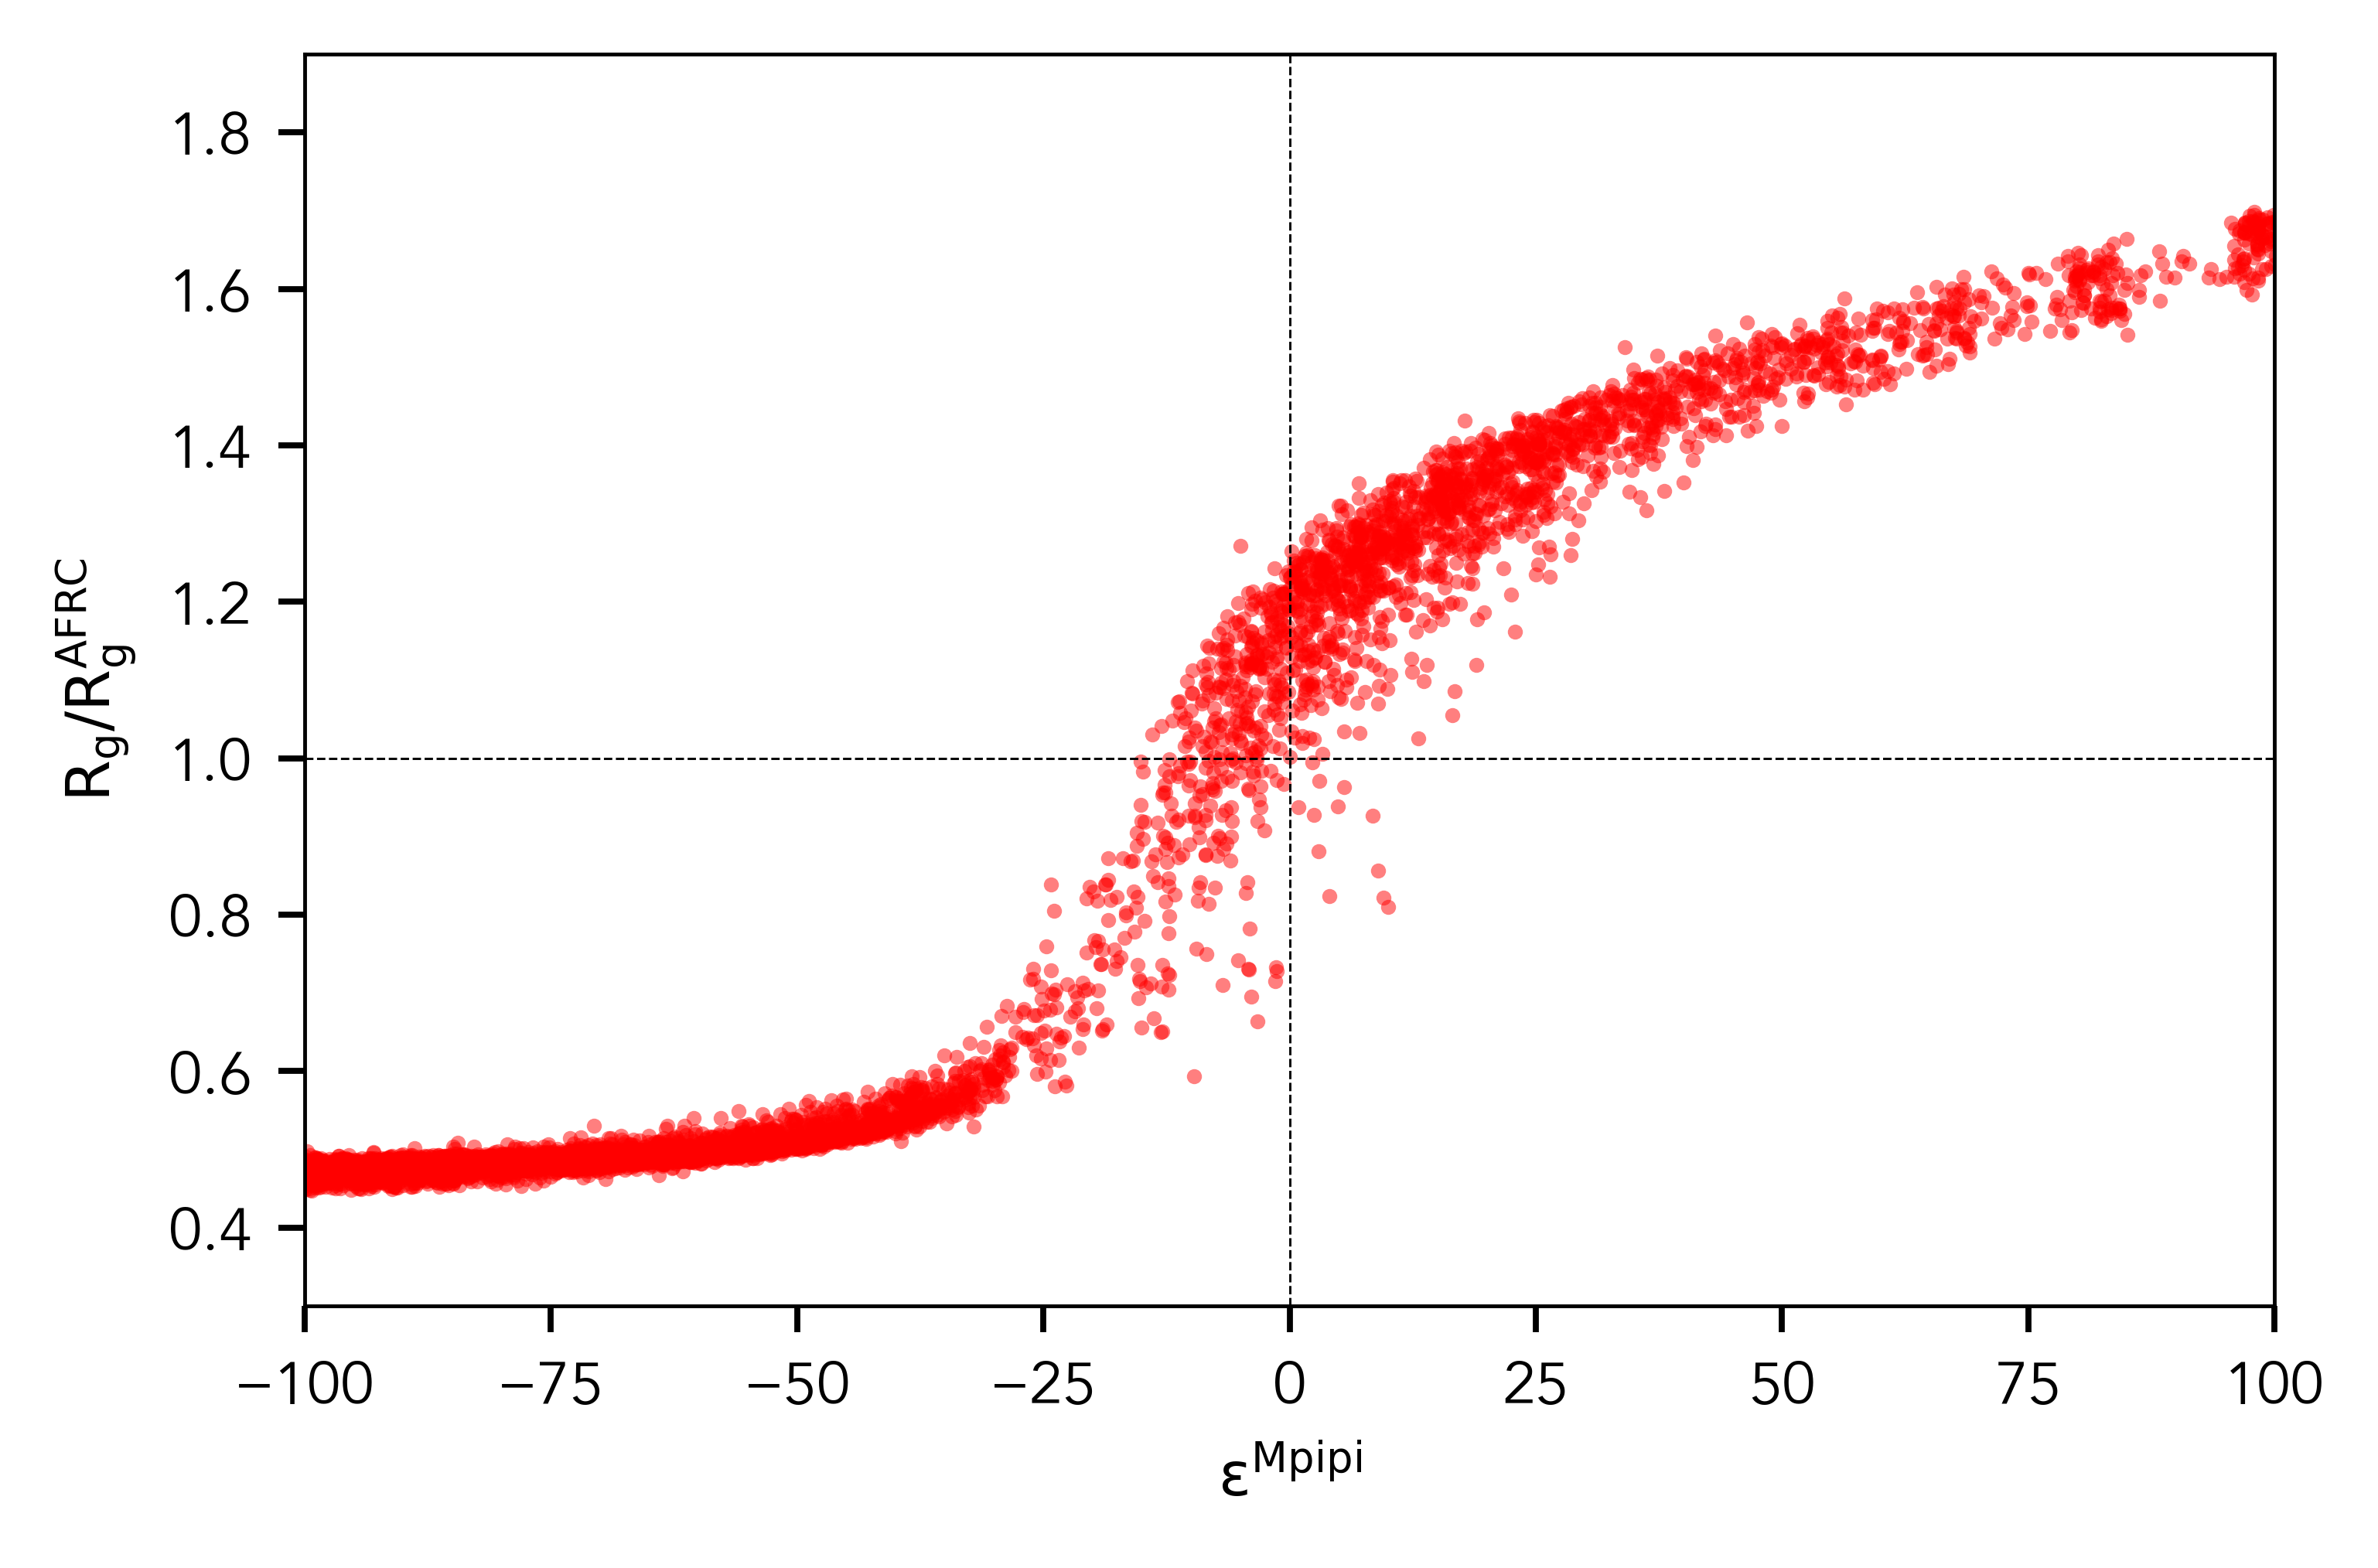

In [21]:
figure(None, (4.5,3), dpi=350)
ax = plt.gca()

#plt.plot(eps,rg,'.k',alpha=0.2,mew=0, ms=2)

plt.plot(nopro_eps_homo,nopro_rg_homo,'.r', alpha=0.5,mew=0, ms=4)
plt.xlim([-100,100])
plt.ylim([0.3,1.9])

ax.axhline(1,color='k',lw=0.3,ls='--')
ax.axvline(0,color='k',lw=0.3,ls='--')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'$\rm \epsilon ^{Mpipi}$',fontsize=8)
plt.ylabel(r'$\rm R_g / R_g^{AFRC}$',fontsize=8)
plt.tight_layout()
plt.savefig('out_figures/rg_vs_eps.pdf')
plt.savefig('out_figures/rg_vs_eps.png', dpi=450)

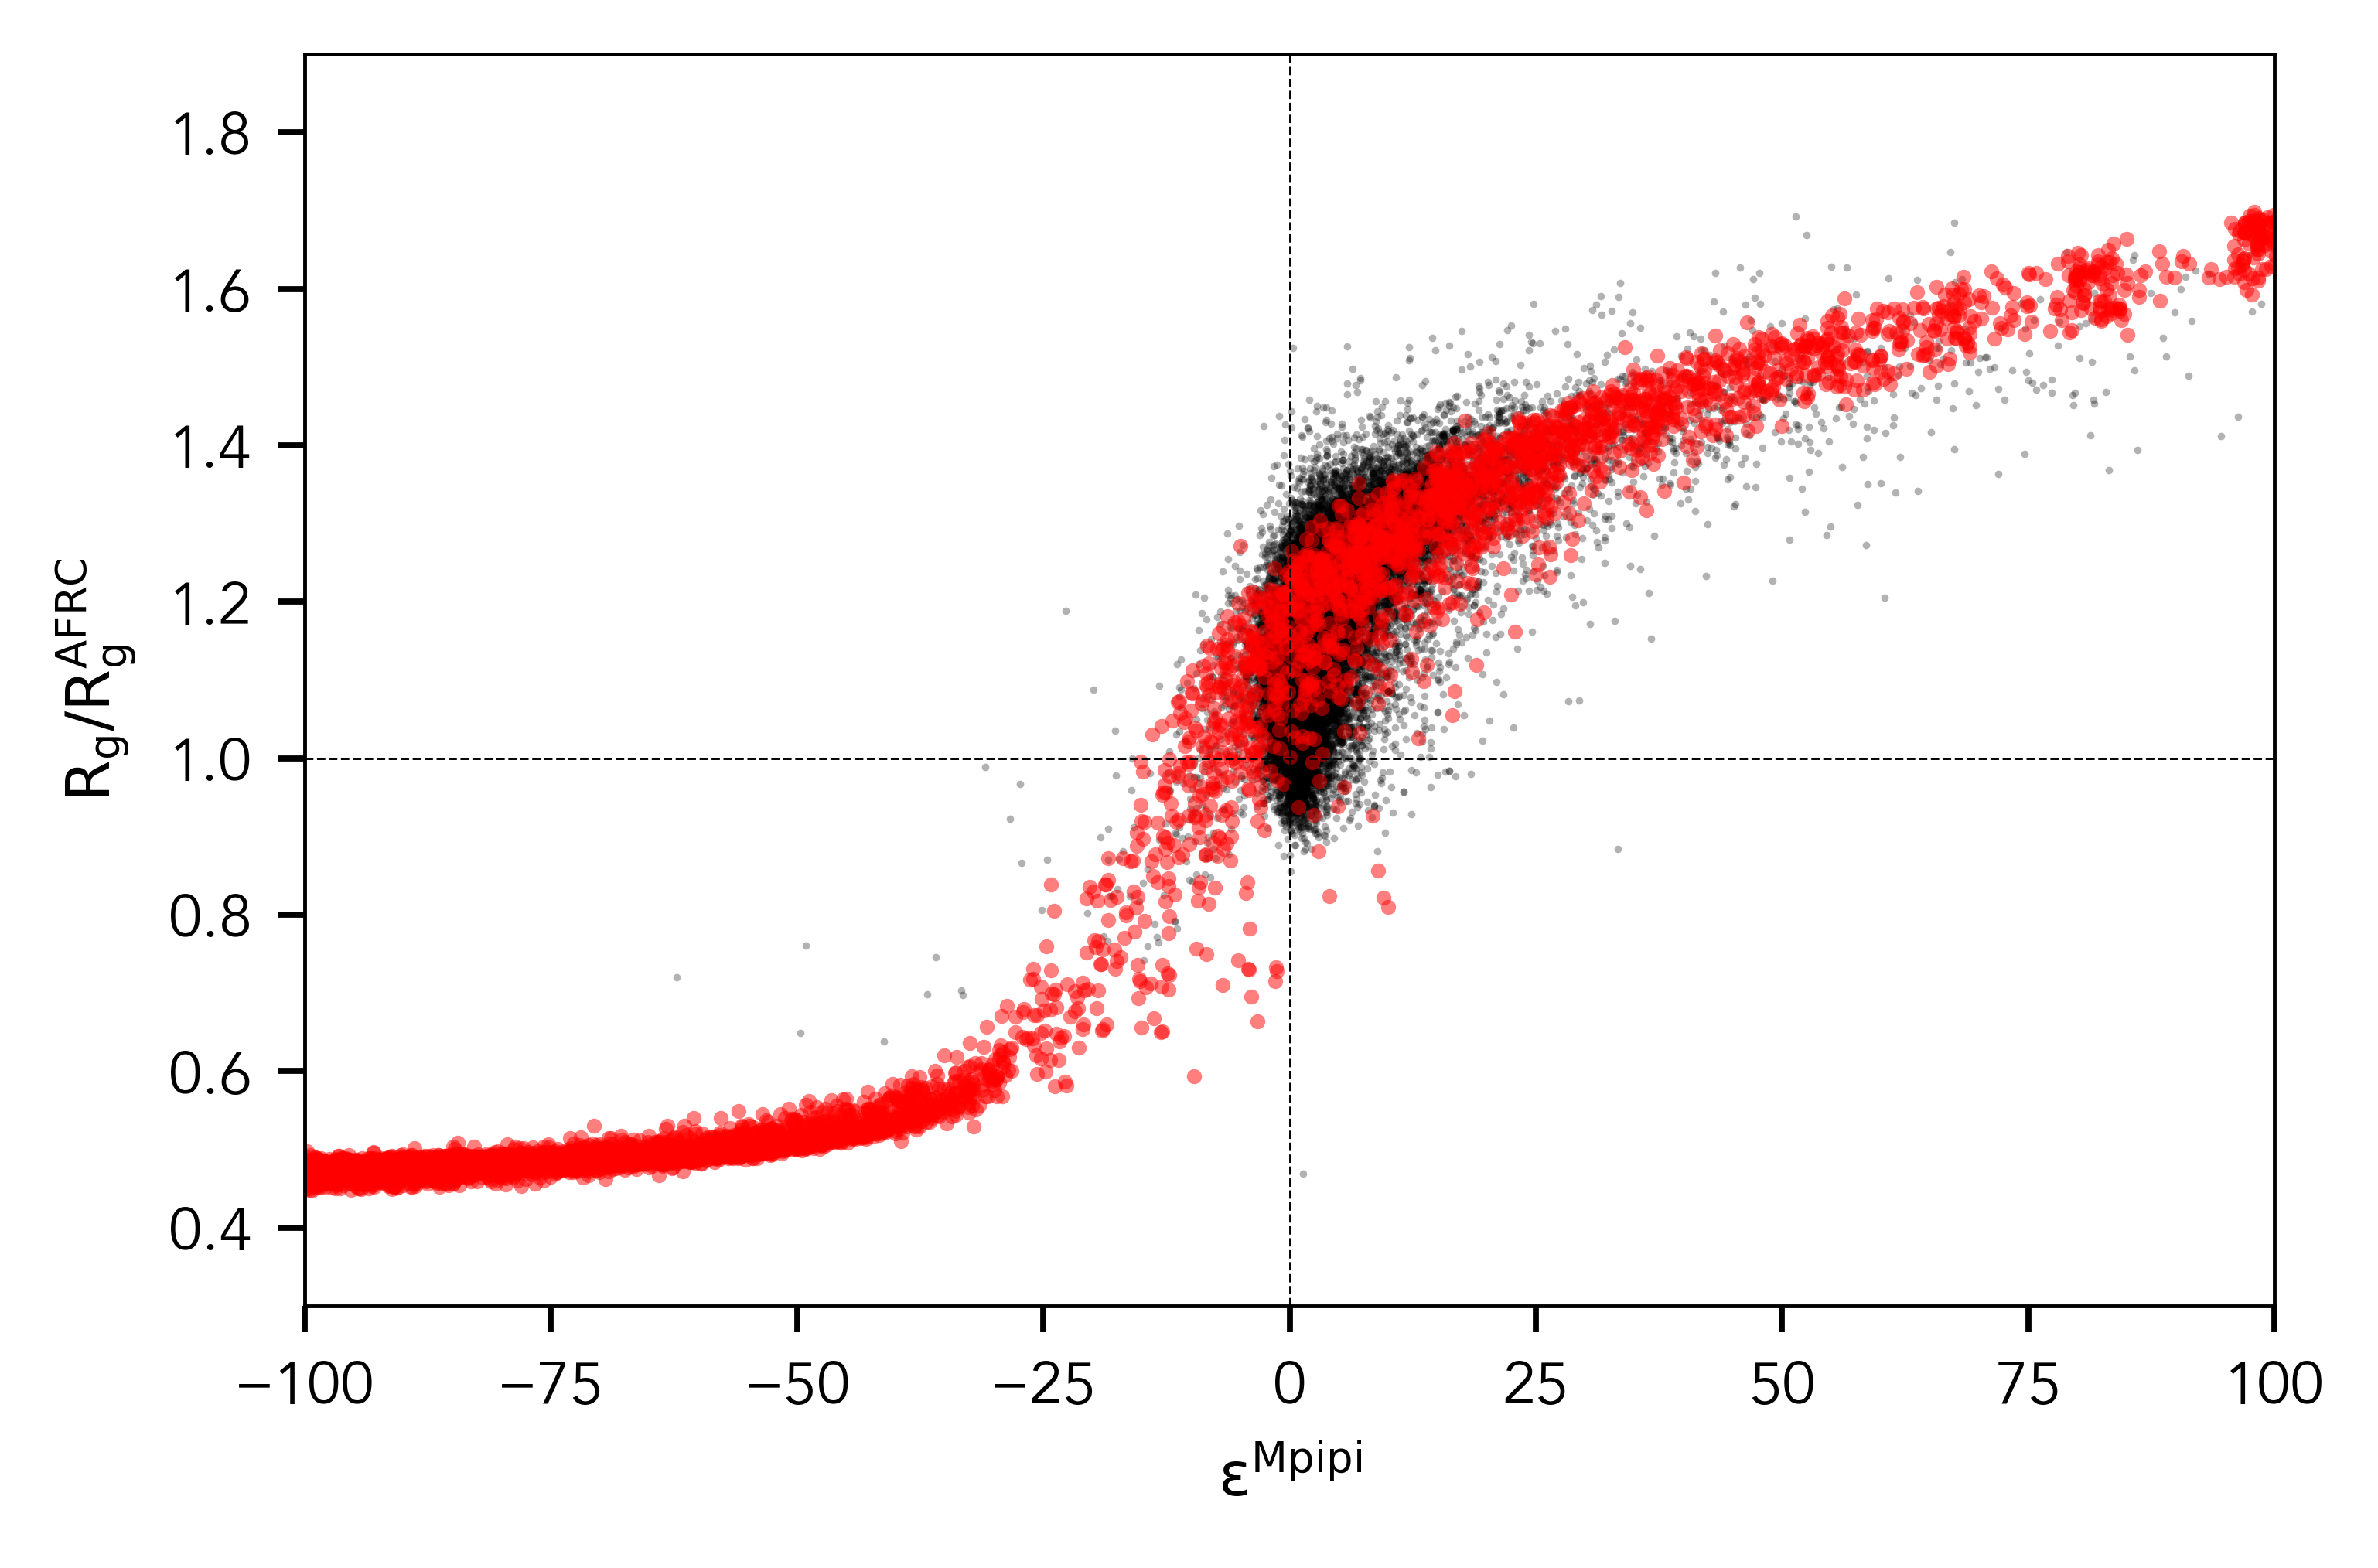

In [20]:
figure(None, (4.5,3), dpi=350)
ax = plt.gca()

#plt.plot(eps,rg,'.k',alpha=0.2,mew=0, ms=2)

plt.plot(eps,rg,'.k', alpha=0.3,mew=0, ms=2)
plt.plot(nopro_eps_homo,nopro_rg_homo,'.r', alpha=0.5,mew=0, ms=4)

plt.xlim([-100,100])
plt.ylim([0.3,1.9])

ax.axhline(1,color='k',lw=0.3,ls='--')
ax.axvline(0,color='k',lw=0.3,ls='--')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'$\rm \epsilon ^{Mpipi}$',fontsize=8)
plt.ylabel(r'$\rm R_g / R_g^{AFRC}$',fontsize=8)
plt.tight_layout()
plt.savefig('out_figures/rg_vs_eps_with_human_IDRome.pdf')
plt.savefig('out_figures/rg_vs_eps_with_human_IDRome.png', dpi=450)